# 📚 Natural Language Processing with Disaster Tweets 💬
 
>- 🎯 Goal: Predict which Tweets are about real disasters and which ones are not

Refrence used : [Link](https://towardsdatascience.com/bert-in-keras-with-tensorflow-hub-76bcbc9417b)

In [1]:
import re
import string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import transformers
from transformers import BertTokenizer
from transformers import TFAutoModel


print(tf.__version__)
print(transformers.__version__)

2.11.0
4.26.1


# 📋 Loading the Data

In [2]:
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
sample_sub = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# 🔨 Preprocessing

In [5]:
#Use regex to clean the data
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags = re.UNICODE)
    return emoji_pattern.sub(r'', text)

def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)

    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text 

def seperate_alphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def cont_rep_char(text):
    tchr = text.group(0) 
    
    if len(tchr) > 1:
        return tchr[0:2] 

def unique_char(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

train['text'] = train['text'].apply(lambda x : remove_url(x))
train['text'] = train['text'].apply(lambda x : remove_punct(x))
train['text'] = train['text'].apply(lambda x : remove_emoji(x))
train['text'] = train['text'].apply(lambda x : decontraction(x))
train['text'] = train['text'].apply(lambda x : seperate_alphanumeric(x))
train['text'] = train['text'].apply(lambda x : unique_char(cont_rep_char,x))

test['text'] = test['text'].apply(lambda x : remove_url(x))
test['text'] = test['text'].apply(lambda x : remove_punct(x))
test['text'] = test['text'].apply(lambda x : remove_emoji(x))
test['text'] = test['text'].apply(lambda x : decontraction(x))
test['text'] = test['text'].apply(lambda x : seperate_alphanumeric(x))
test['text'] = test['text'].apply(lambda x : unique_char(cont_rep_char,x))

# ✂️ Tokenization

In [6]:
seq_len = 256
batch_size = 16
num_samples = len(train)
model_name = 'cardiffnlp/twitter-roberta-base-sentiment'

tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

train_tokens = tokenizer(
    train['text'].tolist(), 
    max_length=seq_len, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True, 
    return_tensors='np'
)

y_train = train['target'].values
labels = np.zeros((num_samples, y_train.max() + 1))
labels[np.arange(num_samples), y_train] = 1

dataset = tf.data.Dataset.from_tensor_slices(
    (
        train_tokens['input_ids'], 
        train_tokens['attention_mask'], 
        labels
    )
)

def map_func(input_ids, masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': masks
    }, labels

dataset = dataset.map(map_func)
dataset = dataset.shuffle(10000).batch(batch_size = batch_size, drop_remainder = True)

split = 0.7
size = int((train_tokens['input_ids'].shape[0] // batch_size) * split)

train_ds = dataset.take(size)
val_ds = dataset.skip(size)

# 🤖 Model Building

In [7]:
model = TFAutoModel.from_pretrained(model_name)

# Two inputs
input_ids = tf.keras.layers.Input(shape = (seq_len,), name = 'input_ids', dtype = 'int32')
mask = tf.keras.layers.Input(shape = (seq_len,), name = 'attention_mask', dtype = 'int32')

# Transformer
# embeddings = model.bert(input_ids, attention_mask=mask)[1]
embeddings = model(input_ids, attention_mask = mask)[0]
embeddings = embeddings[:, 0, :]
# Classifier head
x = tf.keras.layers.Dense(512, activation = 'relu')(embeddings)
# x = tf.keras.layers.Dropout(0.1)(x)
y = tf.keras.layers.Dense(2, activation = 'softmax', name = 'outputs')(x)

bert_model = tf.keras.Model(inputs = [input_ids, mask], outputs = y)

# freeze bert layers
# bert_model.layers[2].trainable = False

optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.BinaryAccuracy()

bert_model.compile(optimizer = optimizer, loss = loss, metrics = [acc])

history = bert_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 10,
    batch_size = batch_size
)

Some layers from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment were not used when initializing TFRobertaModel: ['classifier']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/10
332/332 [==============================] - 224s 563ms/step - loss: 0.4448 - binary_accuracy: 0.7967 - val_loss: 0.3503 - val_binary_accuracy: 0.8588
Epoch 2/10
332/332 [==============================] - 182s 549ms/step - loss: 0.3546 - binary_accuracy: 0.8564 - val_loss: 0.2773 - val_binary_accuracy: 0.8960
Epoch 3/10
332/332 [==============================] - 183s 550ms/step - loss: 0.2965 - binary_accuracy: 0.8820 - val_loss: 0.2142 - val_binary_accuracy: 0.9165
Epoch 4/10
332/332 [==============================] - 183s 550ms/step - loss: 0.2709 - binary_accuracy: 0.8948 - val_loss: 0.1765 - val_binary_accuracy: 0.9366
Epoch 5/10
332/332 [==============================] - 183s 550ms/step - loss: 0.2253 - binary_accuracy: 0.9110 - val_loss: 0.1385 - val_binary_accuracy: 0.9515
Epoch 6/10
332/332 [==============================] - 183s 550ms/step - loss: 0.1738 - binary_accuracy: 0.9337 - val_loss: 0.0932 - val_binary_accuracy: 0.9668
Epoch 7/10
332/332 [====================

# 📊 Model Evaluation

In [8]:
def plot_learning_evolution(r):
    plt.figure(figsize = (12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label = 'Loss')
    plt.plot(r.history['val_loss'], label = 'val_Loss')
    plt.title('Loss evolution during training')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(r.history['binary_accuracy'], label = 'binary_accuracy')
    plt.plot(r.history['val_binary_accuracy'], label = 'test_binary_accuracy')
    plt.title('Accuracy score evolution during trainig')
    plt.legend();

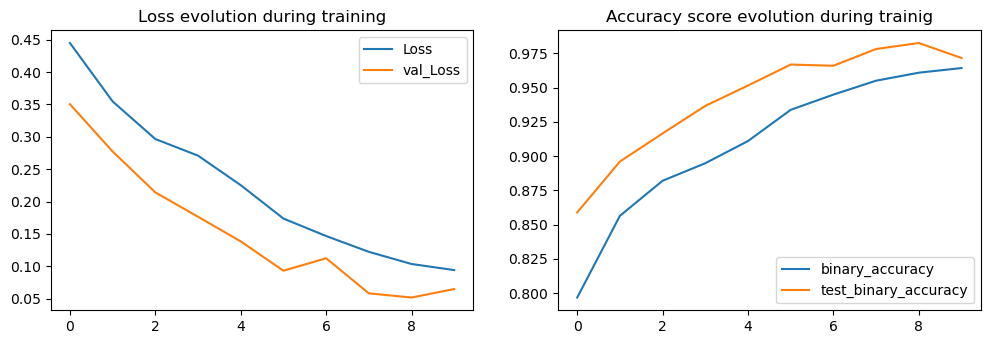

In [9]:
plot_learning_evolution(history)

In [10]:
bert_model.evaluate(val_ds)

143/143 [==============================] - 23s 159ms/step - loss: 0.0537 - binary_accuracy: 0.9795


[0.05373704433441162, 0.9794580340385437]

In [11]:
def prep_data(text):
    tokens = tokenizer(
        text, max_length = 256, truncation = True, 
        padding = 'max_length', 
        add_special_tokens = True, 
        return_tensors = 'tf'
    )
    return {
        'input_ids': tokens['input_ids'], 
        'attention_mask': tokens['attention_mask']
    }

test['target'] = None

for i, row in test.iterrows():
    tokens = prep_data(row['text'])
#     probs = bert_model.predict(tokens)
    probs = bert_model.predict_on_batch(tokens)
    pred = np.argmax(probs)
    test.at[i, 'target'] = pred
    
test['target'] = test['target'].astype(int)

In [12]:
test.head()

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,Heard about earthquake is different cities sta...,1
2,3,NaN,NaN,there is a forest fire at spot pond geese are ...,1
3,9,NaN,NaN,Apocalypse lighting Spokane wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1


In [13]:
test.target.value_counts()

0    2111
1    1152
Name: target, dtype: int64

# 5. Making submission

In [14]:
sub = pd.DataFrame({'id':sample_sub['id'].values.tolist(), 'target':test['target']})
sub.to_csv('submission.csv', index = False)

In [15]:
sub.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


Thanks for sparing your time! Do upvote if you liked it, This motivates hugely to come up with new explorations and keep exploring new domains.

It would be really nice if you check my other works and if you like my work then don't forget to follow for more interesting notebooks 🤗